In [57]:
!pip install git+https://github.com/pydata/xarray.git
!pip install preliz
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-emv_926w
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-emv_926w
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [58]:
import preliz as pz
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

This project I wanted to improve my model from last project by using my newly learned B Spline skills!

A little background, I am trying to predict a movies score (1-10) using a variety of predictors such as buget, gross revenure, and rating (R, TV-MA, PG, etc.)

In [59]:
movies = pd.read_csv('https://raw.githubusercontent.com/ThomasFurtado/Movies-Dataset-IMDb/refs/heads/main/movies.csv')
# Getting rid of empty cells
movies.dropna(inplace=True)

movies

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7648,Bad Boys for Life,R,Action,2020,"January 17, 2020 (United States)",6.6,140000.0,Adil El Arbi,Peter Craig,Will Smith,United States,90000000.0,426505244.0,Columbia Pictures,124.0
7649,Sonic the Hedgehog,PG,Action,2020,"February 14, 2020 (United States)",6.5,102000.0,Jeff Fowler,Pat Casey,Ben Schwartz,United States,85000000.0,319715683.0,Paramount Pictures,99.0
7650,Dolittle,PG,Adventure,2020,"January 17, 2020 (United States)",5.6,53000.0,Stephen Gaghan,Stephen Gaghan,Robert Downey Jr.,United States,175000000.0,245487753.0,Universal Pictures,101.0
7651,The Call of the Wild,PG,Adventure,2020,"February 21, 2020 (United States)",6.8,42000.0,Chris Sanders,Michael Green,Harrison Ford,Canada,135000000.0,111105497.0,20th Century Studios,100.0


This is my generalized linear model from last unit. It was the best version that I tested, so I will be using it as a baselne for the rest of this project (v0)

In [60]:
model_v0 = bmb.Model("score ~ year + budget|gross + rating + year:budget", data=movies)
#fit the model
idata_v0 = model_v0.fit(idata_kwargs={'log_likelihood': True})

Output()

ERROR:pymc.stats.convergence:There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


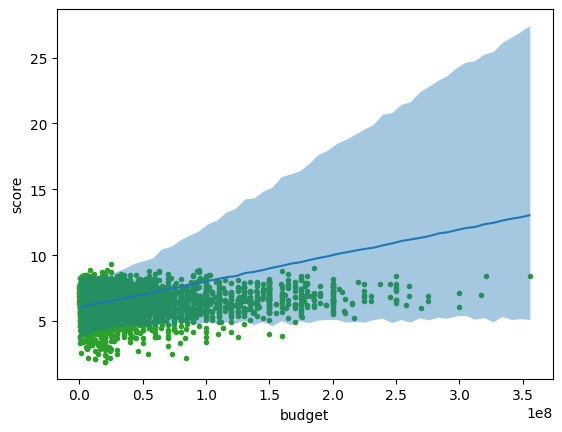

In [85]:
bmb.interpret.plot_predictions(model_v0, idata_v0, "budget", pps=True)
plt.plot(movies.budget, movies.score, "C2.", zorder=-3)

Even though this is my "best model", it's not looking too good. The fit here is horrible. It seem kind of inverted (?). THe predictions should be tapering ogf and decreasing as they approch positive x infinity, but they are doing the excact opposite. However, there is a distinct pattern in the sata, so there is an model to be made with this predictor

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


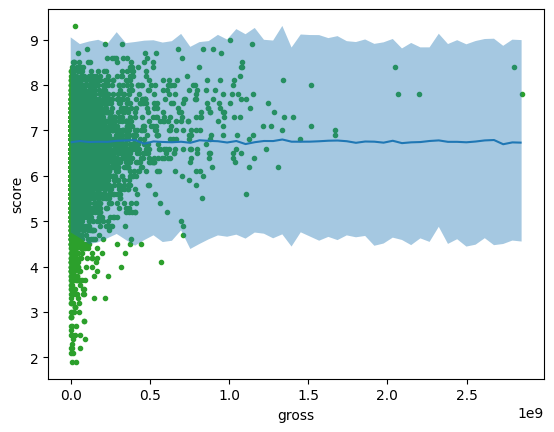

In [86]:
bmb.interpret.plot_predictions(model_v0, idata_v0, "gross", pps=True)
plt.plot(movies.gross, movies.score, "C2.", zorder=-3)

Woah. The fit sucks here too. In hindsight I probably should have done this checking in my last project to see if "best" meant "good". Anintersting thought I have about this graph is what if I swtiched the variables and mad score a predictor and tried to predict gross revenue? That shape looks really familiar and I can already thing of some models that would make a nice fit. Maybe another time...

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


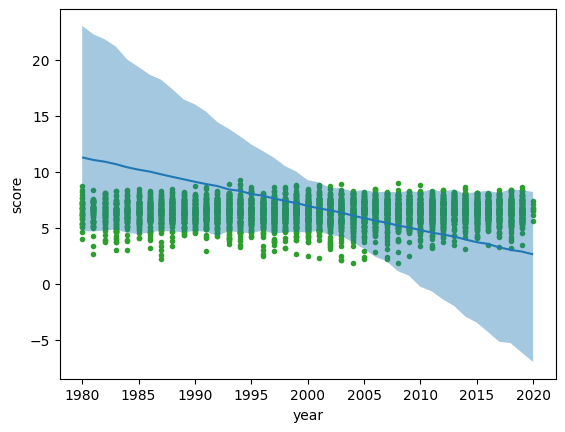

In [87]:
bmb.interpret.plot_predictions(model_v0, idata_v0, "year", pps=True)
plt.plot(movies.year, movies.score, "C2.", zorder=-3)

Not much t say here. I'm probably not going to use year in my new and improved model becase there seems to be little to no correlations at all.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


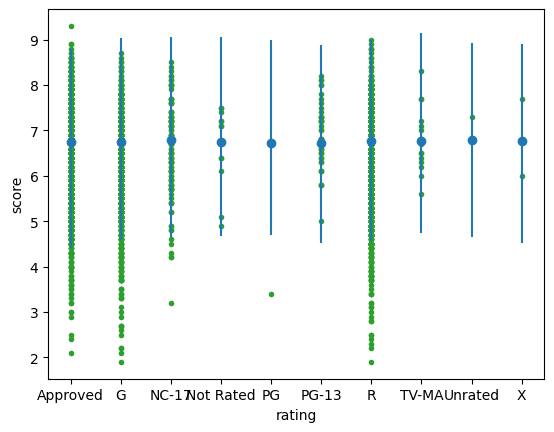

In [88]:
bmb.interpret.plot_predictions(model_v0, idata_v0, "rating", pps=True)
plt.plot(movies.rating, movies.score, "C2.", zorder=-3)

This is a nice graph, I think that it's my favorite one. This is an intersting visualization, adn provides interesting insignts. I'm excited to try to incorperate this predictor into my new models, but I forsee a struggle since it is catagorical...

Overall, this model was pretty bad. The fits were generally just horrible. I don't know if I will be able to visualize my Bsplines, but I do want to make sure that my fit has a significant increase as my elpsLOO rises.

One last note, a Bsplin might not be the move since there isn't too many curves in the data, but its worth a try.

In [76]:
num_knots = 4
knots = [25000000, 50000000, 125000000, 200000000]
model_v1_spline = bmb.Model("score ~ bs(budget, degree=3, knots=knots)", movies, family="negativebinomial")
idata_v1_spline = model_v1_spline.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


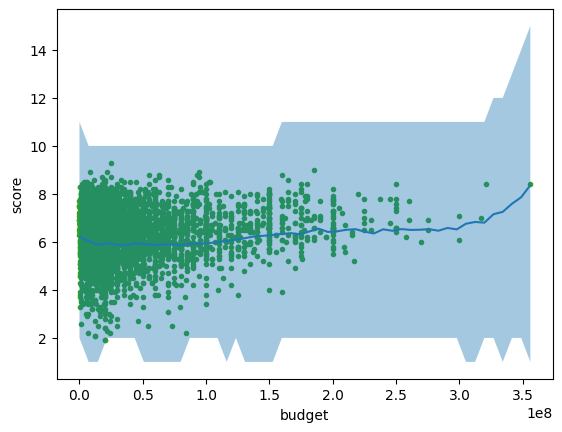

In [63]:
bmb.interpret.plot_predictions(model_v1_spline, idata_v1_spline, "budget", pps= True)
plt.plot(movies.budget, movies.score, "C2.", zorder=-3)

For this model I started by using my numerical predictors to make asimple model. Lookng back, I kind of wish that I didn't hand define my knos, becuase I don't think that I did a good job of it, and it threw off my results. HOWEVER, the fit is much much better.

In [77]:
num_knots_bud = 4
knots_bud = [25000000, 50000000, 125000000, 200000000]
num_knots_grs = 6
knots_grs = [10000000, 250000000,500000000,750000000,1500000000]
model_v2_spline = bmb.Model("score ~ bs(budget, degree=3, knots=knots_bud) + bs(gross, degree=3, knots=knots_grs)", movies)
idata_v2_spline = model_v2_spline.fit(idata_kwargs={'log_likelihood': True})

Output()

After a but if research, I doscovered how to make a multiple predictore Bspline. I wanted to try one with just numerical predictors before I started adding my catagorical one (rating) back in.

In [83]:
num_knots_bud = 4
knots_bud = [25000000, 50000000, 125000000, 200000000]
num_knots_grs = 6
knots_grs = [10000000, 250000000,500000000,750000000,1500000000]
num_knots_rting = 7
knots_rting = ["G", "NC-17", "PG", "PG-13", "R", "TV-MA", "X"]
model_v3_spline = bmb.Model("score ~ bs(budget, degree=3, knots=knots_bud) + bs(gross, degree=3, knots=knots_grs) + bs(rating, degree=3, knots=knots_rting)", movies)
idata_v3_spline = model_v3_spline.fit(idata_kwargs={'log_likelihood': True})


TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


In [80]:
cmp_df = az.compare( {"OGglm":idata_v0,"bspline_single":idata_v1_spline,"bspline_multi":idata_v2_spline} )
cmp_df

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
bspline_multi,0,-7221.319028,14.344778,0.000000,0.97903,66.222172,0.000000,True,log
bspline_single,1,-10337.035891,1.438358,3115.716864,0.02106,10.890776,58.338780,False,log
OGglm,2,-91512.215297,82171.180018,84290.896270,0.00000,1290.354267,1289.882347,True,log


I ran out of time to debug this, but the issue I faced with a catagorical predictor Bslpine was that I couldn't define any knots. Looking ack, I probably could have added the rating as a non Bspline predictor. I'll probably work on it ater submitting this.

All in all, my 2 predicotr Bspline was the best model! I am glad I can improve even further, and I am lowkey really proud of myself.